In [119]:
# Modules
import pandas as pd
import numpy as np

# Model modules
from sklearn.linear_model import LinearRegression

from tableone import TableOne # for the descriptive table

In [109]:
def read_prepare_initial_data(path):
    # Read, prepare, anonimize the initial data
    df = pd.read_sas(path)
    
    # Select only relevant columns
    df = df[['Amzius', 'PSA', 'naujasCT', 'BxGleason', 'Bxkodas', 'RP_GG', 'pT', 
             'LNI01', 'R', 'PSAdaugiau0_1', 'BCR', 'MTS', 'SURVIVAL', 'OS', 'CSS',
             'DAmico', 'Rpgleson', 'TRYSgrupes', 'PLNDO1']]
    
    # Create survival column in years
    df["survival_years"] = df["SURVIVAL"] / 12
    
    # Rename the column names
    df.rename(columns = {'Amzius': 'age', 'PSA': 'psa', 'naujasCT': 'clinical_stage', 
                         'Bxkodas': 'biopsy_gleason_gg', 'RP_GG': 'pathological_gleason_gg',
                         'pT': 'pathologic_stage', 'LNI01': 'lni', 'R': 'surgical_margin_status', 
                         'PSAdaugiau0_1': 'persistent_psa', 'SURVIVAL': 'survival_months', 
                         'BCR': 'bcr', 'MTS': 'mts', 'OS': 'overall_mortality', 
                         'CSS': 'cancer_specific_mortality'}, 
               inplace = True)
    
    # Fill the LNI column NA values with 'unknown' value
    df.fillna({'lni': 'unknown', 'r': 'unknown'}, inplace = True)
    
    # Drop rows with NA values, every row must have 0 NA values
    df.dropna(thresh=df.shape[1], inplace = True)
    
    # Change the data types of categorical columns to 'category'
    df = df.astype({'clinical_stage': 'category', 'biopsy_gleason_gg': 'category', 
                    'pathological_gleason_gg': 'category', 'pathologic_stage': 'category',
                    'lni': 'category', 'surgical_margin_status': 'category', 
                    'persistent_psa': 'category', 'bcr': 'category', 'mts': 'category', 
                    'overall_mortality': 'category', 'cancer_specific_mortality': 'category', 
                    'DAmico': 'category', 'TRYSgrupes': 'category', 'PLNDO1': 'category'})
    
    return df


def desciptive_table(df):
    mytable = TableOne(df, missing=False, rename={'age': 'Age (years)'}, sort=False)
    # print(mytable.tabulate(tablefmt="github"))
    return mytable


def add_target_column(df, target_column, time, survival_column='survival_months'):
    # Function will add a new column which marks patients as '1' if they had an event (died)
    # from 'target_column' by 'time' based on 'survival_column'
    df['target'] = np.where((df[survival_column] < time) & (df[target_column] == 1), 1, 0)
    return df


def split_and_prepare_data(df):
    # Function will split the data into training and testing data and also remove the 
    # other target columns from the data
    X_train, X_test, y_train, y_test = train_test_split(data.drop(['bcr', 'mts', 'overall_mortality', 'cancer_specific_mortality', 'target'], axis=1), 
                                                    data[['target']], test_size=0.20, random_state=1, stratify=data[['target']])
    return X_train, X_test, y_train, y_test

In [105]:
data_path = 'Data/persistentpsa_3.sas7bdat'
data = read_prepare_initial_data(data_path)


In [111]:
temp = add_target_column(data, 'cancer_specific_mortality', 50)
X_train, X_test, y_train, y_test = split_and_prepare_data(temp)

print(X_train.shape, X_test.shape)

(1252, 16) (313, 16)


""
target
0
1


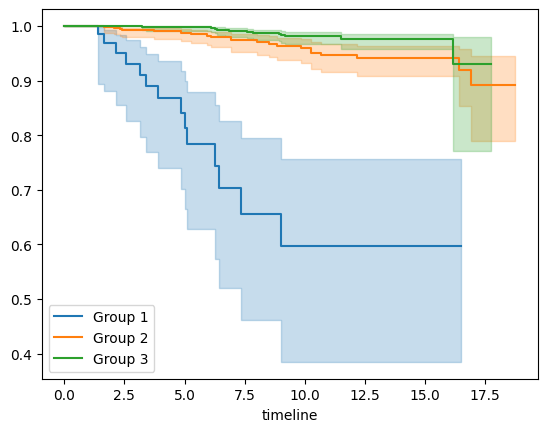

In [75]:
#KM curve
from lifelines import KaplanMeierFitter
group1=data[data['lni']==1]
group2=data[data['lni']==0]
group3=data[data['lni']=='unknown']
T=group1['survival_years']
E=group1['cancer_specific_mortality']
T1=group2['survival_years']
E1=group2['cancer_specific_mortality']
T2=group3['survival_years']
E2=group3['cancer_specific_mortality']

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1").plot_survival_function(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2").plot_survival_function(ax=ax)
ax = kmf.fit(T2, E2, label="Group 3").plot_survival_function(ax=ax)